## Crime Patterns Recognition in LA region project
### Manikanta Katuri and Lakshmi Deepti Pamula - AAI-510 Group 8 

## Business Goal
#### The primary business objective of recognizing crime patterns in the Los Angeles region is to assist law enforcement in identifying crime severity, geographic hotspots, and demographic trends based on age and gender. This enables more effective resource allocation and policy development. A secondary goal is to support public safety initiatives by highlighting high-crime areas and time periods for better community awareness and prevention strategies.

## Loading the data

In [214]:
#@title Loading the required libraries

import numpy as np # Pandas for array manipulation
import pandas as pd # Pandas for data manipulation
import seaborn as sns # Seaborn for visualizing. Note: we will also use one of the data sets
import matplotlib.pyplot as plt # Matplotlib for subplots
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler # Import for feature standardization
from sklearn.metrics import silhouette_samples, silhouette_score # For kmeans evaluation
from sklearn.datasets import load_wine # Used to pull in wine data

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 500)

In [215]:
## Importing the required  libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt #to allow subplot creation

# Apply the seaborn theme
sns.set_theme() #overwrite default Matplotlib styling parameters

#List the example datasets available in seaborn
names = sns.get_dataset_names()
##print("\r\nDatasets in Seaborn: \r\n",names,"\r\n")


# Load train dataset
df = pd.read_csv("Crime_Data_from_2020_to_Present.csv")  
shap = df.shape
print("Shape of the dataframe (row, col):",shap,"\r\n")

# Show the dataframe
df.head()

Shape of the dataframe (row, col): (1005101, 28) 



,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,NaN,0,M,O,101.00,STREET,NaN,NaN,AA,Adult Arrest,510.00,998.00,NaN,NaN,1900 S LONGWOOD AV,NaN,34.04,-118.35
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,47,M,O,128.00,BUS STOP/LAYOVER (ALSO QUERY 124),NaN,NaN,IC,Invest Cont,330.00,998.00,NaN,NaN,1000 S FLOWER ST,NaN,34.04,-118.26
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,0344 1251,19,X,X,502.00,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,480.00,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.02,-118.30
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,19,M,O,405.00,CLOTHING STORE,NaN,NaN,IC,Invest Cont,343.00,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.16,-118.44
4,200412582,09/09/2020 12:00:00 AM,09/09/2020 12:00:00 AM,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.00,STREET,NaN,NaN,IC,Invest Cont,510.00,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.08,-118.21


## 1. Initial Data Exploration and Summary Statistics

In [216]:
def generate_summary_statistics(df):
    """
    Generate comprehensive summary statistics for the dataset.

    Parameters:
    df (pandas.DataFrame): Input DataFrame

    Returns:
    dict: Dictionary containing various summary statistics
    """
    summary = {
        'basic_info': {
            'rows': df.shape[0],
            'columns': df.shape[1],
            'dtypes': df.dtypes.to_dict()
        },
        'numerical_summary': df.describe(),
        'categorical_summary': df.select_dtypes(include=['object']).describe(),
        'memory_usage': df.memory_usage(deep=True).sum() / 1024**2  # in MB
    }

    return summary

# Example usage with Iris dataset
summary_stats = generate_summary_statistics(df)
print("Dataset Overview:")
print(f"Number of samples: {summary_stats['basic_info']['rows']}")
print(f"Number of features: {summary_stats['basic_info']['columns']}")
print("\nNumerical Summary:")
print(summary_stats['numerical_summary'])

Dataset Overview:
Number of samples: 1005101
Number of features: 28

Numerical Summary:
             DR_NO   TIME OCC       AREA  Rpt Dist No   Part 1-2     Crm Cd  \
count   1005101.00 1005101.00 1005101.00   1005101.00 1005101.00 1005101.00   
mean  220224858.64    1339.91      10.69      1115.58       1.40     500.16   
std    13200269.98     651.05       6.11       611.17       0.49     205.26   
min         817.00       1.00       1.00       101.00       1.00     110.00   
25%   210616891.00     900.00       5.00       587.00       1.00     331.00   
50%   220915983.00    1420.00      11.00      1139.00       1.00     442.00   
75%   231110413.00    1900.00      16.00      1613.00       2.00     626.00   
max   252104146.00    2359.00      21.00      2199.00       2.00     956.00   

        Vict Age  Premis Cd  Weapon Used Cd   Crm Cd 1  Crm Cd 2  Crm Cd 3  \
count 1005101.00 1005085.00       327256.00 1005090.00  69156.00   2314.00   
mean       28.91     305.62          363.96 

#### The dataset being used has about a million records with 28 features. Key information that will be used in Clustering are Time based attriutes like Time of crime occurence, Location based feature like Latitude(LAT) and Longitude (LONGITUDE), gender based features like Victim's sex, age based features like Victime age and severity of a crime (Part 1-2), Crime code desc, Premise description. Upon missing data evaluation we will proceed to see  which stratigeis (imputation or dropping) can be applied.

## 2. Missing values



Missing Value Summary:
                missing_count  missing_percentage data_type
DR_NO                       0                0.00     int64
Date Rptd                   0                0.00    object
DATE OCC                    0                0.00    object
TIME OCC                    0                0.00     int64
AREA                        0                0.00     int64
AREA NAME                   0                0.00    object
Rpt Dist No                 0                0.00     int64
Part 1-2                    0                0.00     int64
Crm Cd                      0                0.00     int64
Crm Cd Desc                 0                0.00    object
Mocodes                151706               15.09    object
Vict Age                    0                0.00     int64
Vict Sex               144730               14.40    object
Vict Descent           144742               14.40    object
Premis Cd                  16                0.00   float64
Premis Desc     

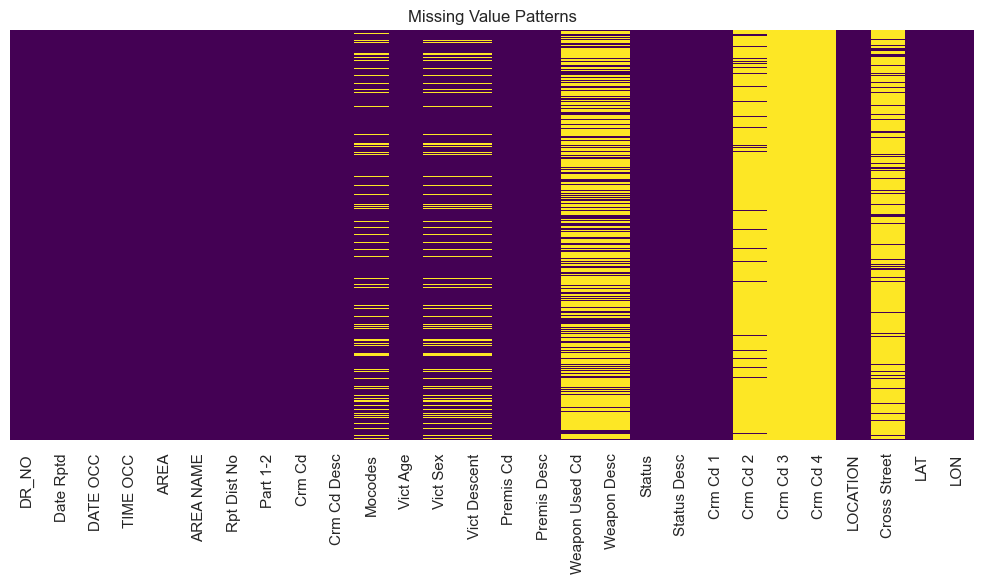

In [217]:
def analyze_missing_values(df):
    """
    Perform comprehensive missing value analysis.

    Parameters:
    df (pandas.DataFrame): Input DataFrame

    Returns:
    dict: Dictionary containing various missing value analyses
    """
    # Basic missing value statistics
    missing_info = pd.DataFrame({
        'missing_count': df.isnull().sum(),
        'missing_percentage': (df.isnull().sum() / len(df) * 100).round(2),
        'data_type': df.dtypes
    })

    # Missing value patterns by location
    missing_by_location = pd.DataFrame({
        col: df.groupby('LOCATION')[col].apply(lambda x: x.isnull().mean() * 100).round(2)
        for col in df.select_dtypes(include=['float64']).columns
    })

    # Analyze missing value relationships
    missing_correlations = df.isnull().corr()

    # Create visualization of missing values using seaborn
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Missing Value Patterns')
    plt.tight_layout()

    return {
        'missing_summary': missing_info,
        'missing_by_location': missing_by_location,
        'missing_correlations': missing_correlations
    }

# Example usage
missing_analysis = analyze_missing_values(df)
print("\nMissing Value Summary:")
print(missing_analysis['missing_summary'])
print("\nMissing Values by Location (%):")
print(missing_analysis['missing_by_location'])

#### From the missing data pattern above we see that  attributes Weapon Used Cd, Weapon Desc, Crime Cd2, 3,4 have have higher percentage of  missing data along with few others. Missing Weapon Cd/Desc is acceptable as not every crime involves a  weapon. Crimes like Vehicle theft, vandalism, shop lifting dont involve a weapon. We would still need this field but we cant use any imputation tecnhique to fill in the weapon information but instead will use a default 'No Weapon'. Since we have Crime cd 1 present for all records, the rest of the Crime codes fields can be ignored for the analyis

## 3. Correlation overview


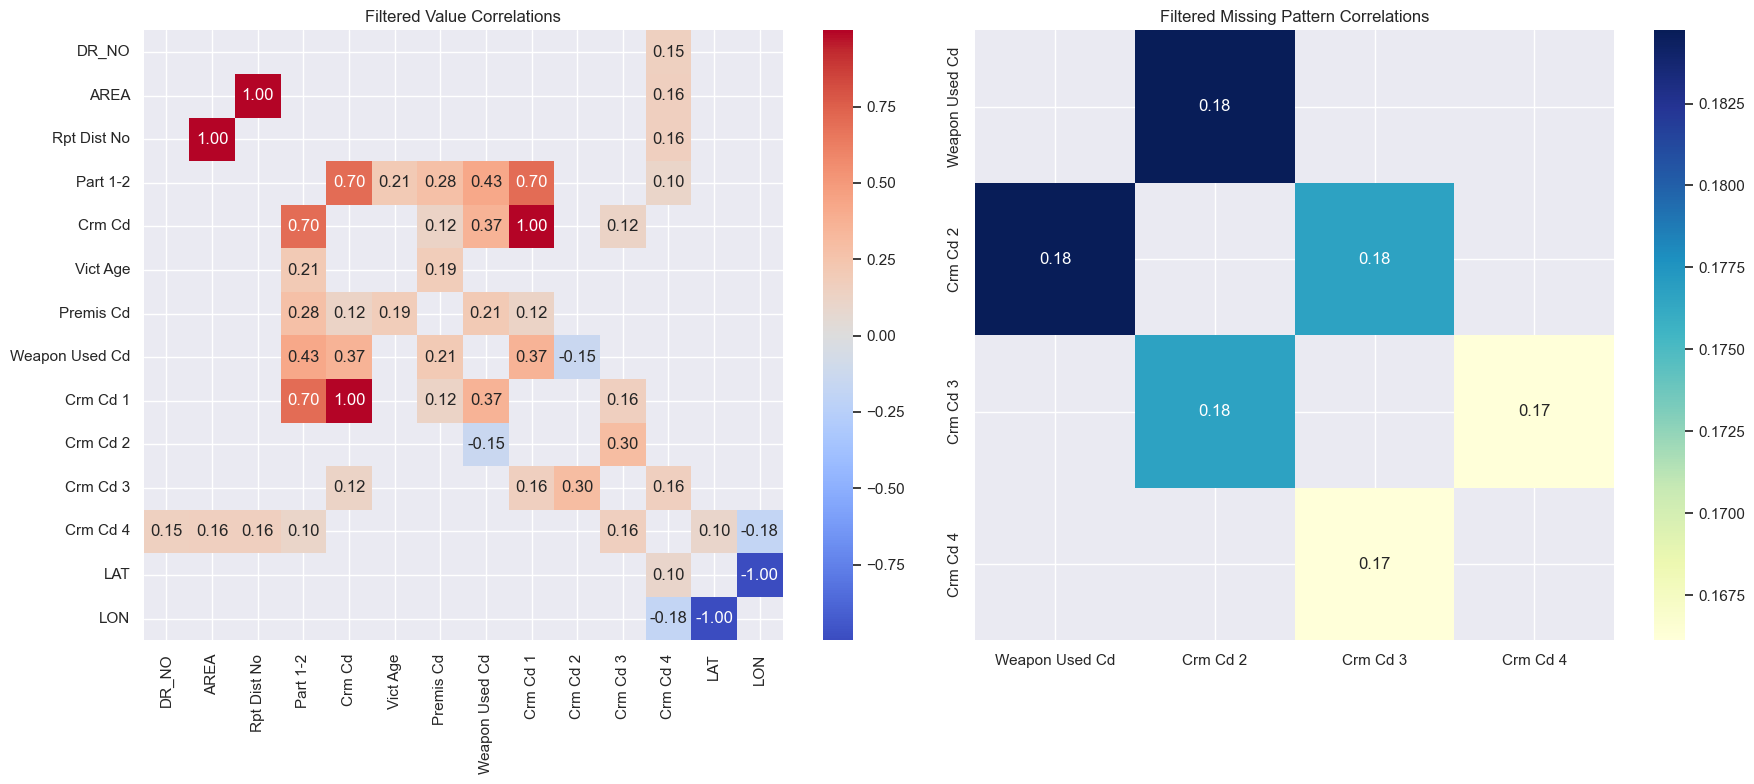


Value Correlations:
                DR_NO  TIME OCC  AREA  Rpt Dist No  Part 1-2  Crm Cd  \
DR_NO            1.00     -0.00  0.03         0.03     -0.04   -0.02   
TIME OCC        -0.00      1.00  0.00         0.00     -0.06    0.01   
AREA             0.03      0.00  1.00         1.00      0.01   -0.01   
Rpt Dist No      0.03      0.00  1.00         1.00      0.01   -0.01   
Part 1-2        -0.04     -0.06  0.01         0.01      1.00    0.70   
Crm Cd          -0.02      0.01 -0.01        -0.01      0.70    1.00   
Vict Age        -0.07     -0.04  0.02         0.02      0.21   -0.02   
Premis Cd        0.03     -0.06 -0.01        -0.01      0.28    0.12   
Weapon Used Cd   0.02     -0.01 -0.02        -0.02      0.43    0.37   
Crm Cd 1        -0.02      0.01 -0.01        -0.01      0.70    1.00   
Crm Cd 2         0.03      0.01 -0.04        -0.04      0.08    0.00   
Crm Cd 3         0.03     -0.01  0.04         0.04      0.01    0.12   
Crm Cd 4         0.15     -0.03  0.16      

In [218]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_correlations(df, method='pearson'):
    """
    Analyze correlations between numerical variables, handling missing values.
    """
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # Correlation of actual values
    correlation_matrix = df[numerical_cols].corr(method=method)
    missing_correlation = df[numerical_cols].isnull().corr()

    # Filtered matrices
    threshold = 0.1
    corr_filtered = correlation_matrix[(abs(correlation_matrix) > threshold) & (correlation_matrix != 1.0)].dropna(how='all').dropna(axis=1, how='all')

    missing_corr_filtered = missing_correlation[(abs(missing_correlation) > threshold) & (missing_correlation != 1.0)].dropna(how='all').dropna(axis=1, how='all')

    # Creating subplots 
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    if not corr_filtered.empty:
        sns.heatmap(corr_filtered, cmap='coolwarm', annot=True, fmt='.2f', ax=axes[0])
        axes[0].set_title('Filtered Value Correlations')
    else:
        axes[0].set_visible(False)

    if not missing_corr_filtered.empty:
        sns.heatmap(missing_corr_filtered, cmap='YlGnBu', annot=True, fmt='.2f', ax=axes[1])
        axes[1].set_title('Filtered Missing Pattern Correlations')
    else:
        axes[1].set_visible(False)

    plt.tight_layout()
    plt.show()

    return {
        'value_correlations': correlation_matrix,
        'missing_correlations': missing_correlation
    }

# Example usage
correlations = analyze_correlations(df)
print("\nValue Correlations:")
print(correlations['value_correlations'])


#### There is a strong correlation between following attribute and hence one of the attribute can be removed
#### Crm Cd 2 and AREA (1.00) ->  redundant feature
#### Rpt Dist No and AREA (1.00) -> as both represent region this seems to be redundant
#### From the missing data correlation we can see that there is a weak correlation between weapon use and crime code 2, indicating that when crime is less severe weapon cd and  crime code 2,3 are  not recorded or likely not used. Crime cd 2,3,4 can be treated as supplementary data."-

## 4. Feature Engineering

#### The project focus on Crime patters for male or female gender for past 3 years. Dropping remaining gender records and date of crime occurence.
#### Features like Crime cd 1 and Part1-2 has strong correlation hence dropping Crime cd 1 column
#### Features like AREA, Premise Cd, Premise description, Cross Street are reduncat as we have LAT, LON
#### Features like Moode, Crm D 2 ,Crm Cd3, Crm Cd 4, Rept Dist No, Weapon used, Weapon Desc , Victim Descent, Status cd, status description are irrelavant to our project focus, date reported. Hence will be dropped
#### We Will be binning Victim Age to get more age group perspective of crime patterns and  Victim Age will then be dropped.
#### Latitude and Longitude will be validated and invalid records will be filterd out

In [219]:
df['Vict Age'].value_counts()

Vict Age
 0      269316
 30      22290
 35      21836
 31      21420
 29      21345
         ...  
 98         71
-2          28
-3           6
-4           3
 120         1
Name: count, Length: 104, dtype: int64

In [220]:
df.drop(df[df['Vict Age'] == 0].index, inplace=True)


In [221]:
df['Vict Sex'].value_counts()

Vict Sex
M    370329
F    354706
X     10606
H       112
Name: count, dtype: int64

In [222]:
# Keep only rows where 'Vict Sex' is either 'M' or 'F'
df = df[df['Vict Sex'].isin(['M', 'F'])]


In [223]:
print(len(df))  # Total number of rows


725035


In [224]:
#Chcecking for invalid LAT LONG values

invalid_lat = df['LAT'].isnull() | (df['LAT'] == 0) | (df['LAT'] < -90) | (df['LAT'] > 90)
invalid_lon = df['LON'].isnull() | (df['LON'] == 0) | (df['LON'] < -180) | (df['LON'] > 180)

count_invalid = (invalid_lat | invalid_lon).sum()
print("Invalid lat lon", count_invalid)



Invalid lat lon 1680


In [225]:
df.drop(df[invalid_lat | invalid_lon].index, inplace=True)

In [226]:
# Make sure 'DATE OCC' is in datetime format first
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')

# Get min and max dates
min_date = df['DATE OCC'].min()
max_date = df['DATE OCC'].max()

print(f"Minimum DATE OCC: {min_date}")
print(f"Maximum DATE OCC: {max_date}")


C:\Users\dpamu\AppData\Local\Temp\ipykernel_22952\1535027545.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')


Minimum DATE OCC: 2020-01-01 00:00:00
Maximum DATE OCC: 2025-04-01 00:00:00


In [227]:
# Ensure DATE OCC is datetime -
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')

# Filter for years 2023, 2024, and 2025
df = df[df['DATE OCC'].dt.year.isin([2023, 2024, 2025])]


In [228]:
print(len(df))  # Total number of rows


240556


### Dropping redundant attriutes



In [229]:
#Dropping due high cardinality for one hot encoding. will be using LAT/LONG, zipcode instead
df.drop(['LOCATION'], axis=1, inplace=True)

In [230]:
#dropping redundant code fields as we have descripton fields and unnecessary fields
df.drop(['Crm Cd','Mocodes','AREA','Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4','Rpt Dist No','Cross Street','Weapon Used Cd', 'Status','Premis Cd','Weapon Desc',
        'Vict Descent','Status Desc','Premis Desc'], axis=1, inplace=True)

In [231]:
# Checking TIME OCC is a 4-digit string 
df['TIME OCC'] = df['TIME OCC'].astype(str).str.zfill(4)
# Extract hour
df['hour'] = df['TIME OCC'].str[:2].astype(int)

In [232]:
#Dropping due to irrelevance and redundance
df.drop(['DATE OCC','TIME OCC'], axis=1, inplace=True)

In [233]:
# Defining age bins and corresponding labels
age_bins = [0, 12, 18, 35, 60, 120]  # 0-12=Child, 13-18=Teen, 19-35=Young Adult, etc.
age_labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Senior']

# Creating age group column
df['Victim_Age_Group'] = pd.cut(df['Vict Age'], bins=age_bins, labels=age_labels, right=False)


In [234]:
df.drop(['DR_NO', 'Date Rptd'], axis=1, inplace=True)


In [235]:
df.head()

,AREA NAME,Part 1-2,Crm Cd Desc,Vict Age,Vict Sex,Crm Cd 1,LAT,LON,hour,Victim_Age_Group
644982,Central,1,THEFT PLAIN - PETTY ($950 & UNDER),48,M,440.00,34.04,-118.27,16,Adult
644983,N Hollywood,1,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",36,F,230.00,34.17,-118.36,10,Adult
644984,Central,1,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,25,F,331.00,34.04,-118.27,8,Young Adult
644985,Hollywood,2,INTIMATE PARTNER - SIMPLE ASSAULT,65,F,626.00,34.10,-118.31,1,Senior
644986,Topanga,1,ROBBERY,31,F,210.00,34.19,-118.56,7,Young Adult


In [236]:
df.drop(['AREA NAME', 'Crm Cd Desc','Vict Age', 'Crm Cd 1'], axis=1, inplace=True)

In [237]:
fields = df.columns.tolist()
print(fields)


['Part 1-2', 'Vict Sex', 'LAT', 'LON', 'hour', 'Victim_Age_Group']


In [238]:
df.head()

,Part 1-2,Vict Sex,LAT,LON,hour,Victim_Age_Group
644982,1,M,34.04,-118.27,16,Adult
644983,1,F,34.17,-118.36,10,Adult
644984,1,F,34.04,-118.27,8,Young Adult
644985,2,F,34.10,-118.31,1,Senior
644986,1,F,34.19,-118.56,7,Young Adult


### 5. One Hot Encoding
#### One hot encoding will be applied to Victim sex (giving 2 columns) and Victim Age group (giving 5 groups)

In [239]:
import pandas as pd

# 1. Keep only 'M' and 'F' values
df = df[df['Vict Sex'].isin(['M', 'F'])]

# 2. One-hot encode Vict Sex
df = pd.get_dummies(df, columns=['Vict Sex'], prefix='Vict_Sex', drop_first=False)


In [240]:
import pandas as pd

# 1. Keep only 'M' and 'F' values
df = df[df['Victim_Age_Group'].isin(['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])]

# 2. One-hot encode Vict Sex
df = pd.get_dummies(df, columns=['Victim_Age_Group'], prefix='Vict_Age', drop_first=False)


In [241]:
df.head()

,Part 1-2,LAT,LON,hour,Vict_Sex_F,Vict_Sex_M,Vict_Age_Child,Vict_Age_Teen,Vict_Age_Young Adult,Vict_Age_Adult,Vict_Age_Senior
644982,1,34.04,-118.27,16,False,True,False,False,False,True,False
644983,1,34.17,-118.36,10,True,False,False,False,False,True,False
644984,1,34.04,-118.27,8,True,False,False,False,True,False,False
644985,2,34.10,-118.31,1,True,False,False,False,False,False,True
644986,1,34.19,-118.56,7,True,False,False,False,True,False,False


In [242]:
fields = df.columns.tolist()
print(fields)


['Part 1-2', 'LAT', 'LON', 'hour', 'Vict_Sex_F', 'Vict_Sex_M', 'Vict_Age_Child', 'Vict_Age_Teen', 'Vict_Age_Young Adult', 'Vict_Age_Adult', 'Vict_Age_Senior']


### 6. Scaling
#### Scaling is need because some of the features have higher differences than the others. Without scaling these larger differences will dominate the distance metrics leading to biased clusters. 

In [243]:
df.isnull().sum()


Part 1-2                0
LAT                     0
LON                     0
hour                    0
Vict_Sex_F              0
Vict_Sex_M              0
Vict_Age_Child          0
Vict_Age_Teen           0
Vict_Age_Young Adult    0
Vict_Age_Adult          0
Vict_Age_Senior         0
dtype: int64

In [244]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Part 1-2', 'LAT', 'LON',  'Vict_Sex_F', 'Vict_Sex_M', 'Vict_Age_Child', 'Vict_Age_Teen', 'Vict_Age_Young Adult', 'Vict_Age_Adult', 'Vict_Age_Senior']])


In [245]:
type(scaled_data)


numpy.ndarray

## 7. Clustering

#### As we have 250k records we chose the following models for their ability to handle large datasets. We chose this option as opposed to sampling to get better accuracy.
#### MiniBatchKMeans : Faster, memory-efficient version of KMeans, using small random batches instead of the whole dataset for updates.
#### Gaussian Mixture : Flexible model that is probabilistic, allowing soft clustering (a point can belong to multiple clusters with different probabilities). This is useful as we belive there may be overlap in clusters.
#### Birch model (Balanced Iterative Reducing and Clustering using Hierarchies): Efficient at handling large datasets by incrementally builiding clustering tree and compressing data in memory.

#### Other algorithms took lot of compute resoures and long time process. The above mentioned models worked quickly and giving a moderate Silhoute scores.



In [246]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np


# 1. MiniBatchKMeans
mini_kmeans = MiniBatchKMeans(n_clusters=5, batch_size=10000, random_state=42)
mini_labels = mini_kmeans.fit_predict(scaled_data)
mini_silhouette = silhouette_score(scaled_data, mini_labels)

# 2. Gaussian Mixture
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(scaled_data)
gmm_silhouette = silhouette_score(scaled_data, gmm_labels)

# 3. Birch
birch = Birch(n_clusters=5) an
birch_labels = birch.fit_predict(scaled_data)
birch_silhouette = silhouette_score(scaled_data, birch_labels)

# Prepare result summary
result_df = pd.DataFrame({
    'Algorithm': ['MiniBatchKMeans', 'GaussianMixture', 'Birch'],
    'Silhouette Score': [mini_silhouette, gmm_silhouette, birch_silhouette]
})

print("Clustering Comparison Results:")
print(result_df)



Clustering Comparison Results:
         Algorithm  Silhouette Score
0  MiniBatchKMeans              0.27
1  GaussianMixture              0.30
2            Birch              0.30


In [247]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=5, batch_size=10000, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_data)


In [248]:
from sklearn.metrics import silhouette_score

score = silhouette_score(scaled_data, df['cluster'])
print(f"Silhouette Score: {score:.4f}")


Silhouette Score: 0.2652


In [251]:
df['mini_labels'] = mini_labels
df['gmm_labels'] = gmm_labels
df['birch_labels'] = birch_labels

In [252]:
print("MiniBatchKMeans label counts:")
print(df['mini_labels'].value_counts())

print("Gaussian label counts:")
print(df['gmm_labels'].value_counts())

print("Birch label counts:")
print(df['birch_labels'].value_counts())


MiniBatchKMeans label counts:
mini_labels
3    83909
1    61848
4    51053
0    37236
2     6508
Name: count, dtype: int64
Gaussian label counts:
gmm_labels
2    58876
3    55575
4    51854
0    43555
1    30694
Name: count, dtype: int64
Birch label counts:
birch_labels
1    100304
4     94145
0     37711
2      6508
3      1886
Name: count, dtype: int64


## 8. Visualization

#### Using Guassian Mixture results due to high Silhouette scores

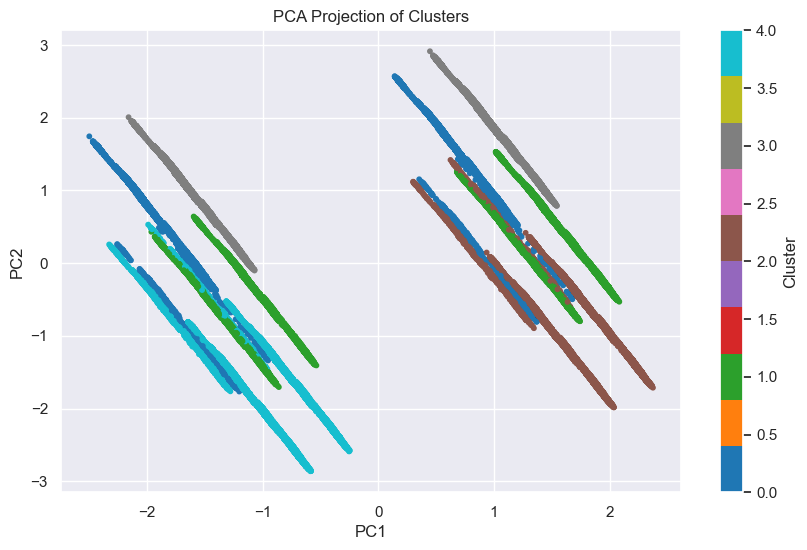

In [255]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Scatter plot with cluster labels
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['gmm_labels'], cmap='tab10', s=10)
plt.title("PCA Projection of Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


In [256]:

# Now group by cluster and describe the features
df.groupby('gmm_labels')[['Part 1-2','Vict_Age_Child', 'Vict_Age_Teen', 'Vict_Age_Young Adult','Vict_Age_Adult', 'Vict_Age_Senior',
                       'Vict_Sex_M', 'Vict_Sex_F', 'hour', 'LAT', 'LON']].mean()


,Part 1-2,Vict_Age_Child,Vict_Age_Teen,Vict_Age_Young Adult,Vict_Age_Adult,Vict_Age_Senior,Vict_Sex_M,Vict_Sex_F,hour,LAT,LON
gmm_labels,,,,,,,,,,,
0,1.99,0.04,0.00,0.96,0.00,0.00,0.39,0.61,12.73,34.07,-118.35
1,1.47,0.00,0.00,0.00,0.00,1.00,0.54,0.46,13.02,34.08,-118.38
2,1.39,0.00,0.05,0.00,0.95,0.00,1.00,0.00,13.24,34.09,-118.37
3,1.00,0.00,0.00,1.00,0.00,0.00,0.54,0.46,13.57,34.07,-118.35
4,1.55,0.00,0.07,0.00,0.93,0.00,0.00,1.00,13.18,34.07,-118.36


In [257]:
df.groupby('gmm_labels')['Part 1-2'].value_counts(normalize=True)


gmm_labels  Part 1-2
0           2          0.99
            1          0.01
1           1          0.53
            2          0.47
2           1          0.61
            2          0.39
3           1          1.00
4           2          0.55
            1          0.45
Name: proportion, dtype: float64

### 9. Business Value - Gaussian Mixture Model
#### From the above breakdown, we can see that for 
#### Cluster 0 - Majority of the victims were female young adults  and that the location of crime occurence is at Lat: 34.07 Long: -118.35 occuring around 1 pm with severity of crime being 2 (non serious crimes).This indicates some sort of petty theft or property crimes happening during lunch hours affecting young adults. So launching programs to make female commuters aware of the area will help combat the crime.
#### Cluster 1 - All of the victims are elderly with a mix of both male and female victims with server of crime being a mix of serious and non serious. This shows vulnerability for seniors so having Senior safety awareness would help reduce the crime.
#### Cluster 2- All of the victims are male  with higher percentage of adults victims with small percentage of teenagers. Majority of the crimes in this cluster are of non serious crimes so this can be treated as lower priority incidents. This would save the police enforcement to focus on serious crime clusters.
#### Cluster 3 : This cluster captures serious crimes with young adults with equal mix of male and females happening around Lat: 34.07 Lon: -118.35 happening around 1 pm. These could be street violence or assaults. This would be helpful for police to survelience the area and priotize their resources
#### Cluster 4: All victims are Female  with majority yound adults and small portion of teenagers as well with crime occruning around 1 pm . Since there is equal mix of serious and non serious crimes this could imply domestic violence or gender based crimes. This would be hellpful in planning and prioritising outreach programs for women to bring awareness.

#### Based on above insights from Clusters we have following recommendations:
#### 1. Police departments should use cluster insights for proactive resource allocation.
#### 2. Design tailored outreach and safety campaigns based on victim demographics.
#### 3. Expand the model by incorporating real-time feeds, geographic trends, and repeat offense patterns.
#### 4. Engage with local community organizations to raise awareness in areas identified as high-risk.


### Deployment

#### The model can be transitioned into production through strategic integration into crime monitoring and public safety systems. The deployment plan involves:
#### Operationalizing cluster insights for use in daily or weekly police patrolling schedules, targeting identified high-risk zones and vulnerable demographics.
#### Launching targeted outreach programs, such as:
#### Senior safety awareness for clusters involving elderly victims.
#### Women’s safety initiatives in areas with high female victimization rates.
#### Scheduling automated updates to ingest new crime data (weekly or monthly), enabling the system to reflect the latest crime trends and support dynamic resource allocation.

### Implementation Steps:
#### To support this deployment, a crime analytics pipeline can be developed with the following components:
#### Data Ingestion: Automatically retrieve updated crime records.
#### Data Preprocessing: Filter relevant features, apply encoding, and scale inputs.
#### Cluster Labeling: Apply the trained Gaussian Mixture Model to assign clusters.
#### Visualization: Display crime patterns on an interactive map with clustering overlays.
#### Alert Generation: Identify and flag high-risk areas or vulnerable population groups like elderly or women.

### Deployment Infrastructure:
#### This solution can be hosted on scalable cloud platforms such as AWS, Azure, or Google Cloud to ensure high availability and cost effective scaling along with real time integration with police enforcement systems.


###